In [1]:
# from iotbx import cif
# from iotbx.data_manager import DataManager
# import os
# os.environ["MMTBX_CCP4_MONOMER_LIB"] = "/Users/user/software/phenix/modules/chem_data/geostd"

In [1]:
import sys
sys.path.append("../phenix_fragments/")

In [2]:
from graph.utils import build_atom_graph_from_mol, build_fragment_graph

/opt/anaconda3/envs/restraintsML6/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from mol.mols import MolInputGeo, Mol
from pathlib import Path
from mol.cif import load_cif_file, guess_cif_format
from mol.rdkit import validate_rdkit_mol

In [4]:
from fragmentation.fragmenters import BondFragmenter
from graph.molgraph import MolGraph, MolGraphDataset
from graph.message_passing import MessagePassingBonded
from graph.readout import ReadoutSimple

In [5]:
import torch

In [6]:
# dm = DataManager()
# file = Path("../data/PO_data/12AS/output/12AS.updated.pdb")
# dm.process_model_file(str(file))
# dm.process_restraint_file("../data/PO_data/12AS/output/restraints/AMP.cif")
# model = dm.get_model()
# model.process(make_restraints=True)

# mol = Mol.from_cctbx_model(model)
# molecule_id = file.stem.split(".")[0]
# mol.molecule_id = molecule_id

In [7]:
folder = Path("../data/geostd/")
files = [file for file in folder.glob("**/*") if file.suffix == ".cif" and "ccd" not in file.name and "lib" not in file.name]

In [8]:
import tqdm
import numpy as np

In [9]:
mols = []
known_blacklist = ['R79', 'R46', 'R3E', 'RDR', 'R19', 'RIG', 'R3B', 'RE3', 'RE0', 'R04', 'R01', 'RRP', 'R03', 'R17', 'R1A', 'R71', 'RTQ', 'RTR', 'U', 'UN2', 'UZ7', 'U49', 'U66', 'U5Y', 'URG', 'UIZ', '9ZM', '9NV', '95A', '9NE', '9NR', '9NF', '0A8', '0CS', '0BR', '07O', '0AH', '0N1', '0AK', '0E2', '0GM', '0E3', '0D5', '030', '0FL', '000', '02O', '0PN', '02L', '013', '01F', '0AF', '0ZM', '0A1', '0AR', '0LF', '0BN', '7C2', '7AZ', '7C0', '7NX', '7LT', '7LW', 'IV7', 'ILX', 'IBU', 'IAM', 'IRI', 'I21', 'IEL', 'I2M', 'IYR', 'INM', 'ILE', 'ICY', 'IZO', 'NEP', 'NDT', 'ND4', 'NKJ', 'N31', 'NGH', 'N2C', 'NDG', 'NDP', 'NAL', 'NMM', 'NBQ', 'NOT', 'NMQ', 'NMR', 'NCY', 'NCO', 'NAG', 'NNH', 'NYS', 'NLE', 'NMC', 'low', 'NO', 'NIY', 'N1B', 'N0P', 'NPI', 'NPH', 'NGA', 'GME', 'GLU', 'GVL', 'GPL', 'G2O', 'G', 'GEK', 'GD', 'GHG', 'GT9', 'GAL', 'GLJ', 'GLY', 'G9R', 'GLN', 'GOV', 'GVB', 'GND', '6CW', '6VB', '6QG', '6Q1', '6HN', '6CH', '6VJ', '6CL', '6T3', 'ZBZ', 'Z70', 'ZCL', 'ZSW', 'ZSV', 'Z01', 'ZKG', 'ZRL', 'ZZD', '1PA', '12W', '1TY', '143', '193', '1ZX', '1TQ', '1X6', '10R', '82J', '8Q4', '85A', 'TYI', 'TCQ', 'TNB', 'T5B', 'TBR', 'TLY', 'TYX', 'TY9', 'TYO', 'TYN', 'TY8', 'TYY', 'TNR', 'TBG', 'TIS', 'TPQ', 'TRN', 'TRX', 'TRO', 'TEF', 'T0I', 'THR', 'TS9', 'TQQ', 'TQI', 'TRP', 'TRF', 'TEO', 'TIH', 'TPJ', 'T11', 'T3Y', 'TUB', 'T5H', 'TC9', 'TY5', 'TTS', 'TYQ', 'T58', 'TYR', 'TY2', 'TYS', 'TD', 'SIB', 'SEB', 'SIA', 'SDP', 'S1H', 'SEP', 'SD4', 'S2P', 'SHC', 'SRM', 'SER', 'SLZ', 'SUN', 'SLL', 'SY9', 'SVW', 'SVV', 'SAH', 'SCS', 'SNC', 'S5W', 'SCH', 'SMC', 'SVZ', 'SME', 'SVX', 'SVY', 'SXE', 'SEM', 'AN8', 'A5N', 'ALA', 'ALC', 'AAD', 'AZY', 'AR4', 'AGT', 'ASP', 'ARV', 'ARS', 'AGS', 'APM', 'ARG', 'AGQ', 'A', 'ADP', 'ASN', 'ASL', 'AHP', 'A25', 'AGM', 'ARO', 'ALN', 'ALY', 'AAH', 'AZS', 'AD', 'A9A', 'AR', 'FEO', 'FRQ', 'FHO', 'FHL', 'FLT', 'FUC', 'FLA', 'FOL', 'FNH', 'FU0', 'FT6', 'FTY', 'F4S', 'FWQ', 'FRM', 'F2F', 'FFM', 'F3S', 'link', 'exafs', 'crg', 'alpha2-6', 'OTY', 'ON6', 'OC1', 'OCS', 'OAZ', 'OXX', 'O7N', 'OBS', 'OLZ', 'OBF', 'OMH', 'OHI', 'OEX', 'ORQ', 'O12', 'OSE', 'OM3', 'OCY', 'OM2', 'ONH', 'OTQ', 'OAS', 'OMT', 'OTB', 'OXV', 'ONL', 'HIC', 'HS8', 'HIS', 'HPE', 'HQA', 'HGL', 'HIQ', 'H8T', 'HTI', 'HVA', 'HNC', 'HCS', 'HZP', 'HLU', 'HAR', 'HOX', 'HFS', 'HRP', 'HRG', 'HHK', 'list', 'MYK', 'MCS', 'low', 'MO1', 'MMO', 'MAN', 'MTY', 'MXI', 'MB0', 'MBQ', 'MLX', 'MLY', 'MNQ', 'MIR', 'MEQ', 'ME0', 'M2S', 'MIS', 'MSL', 'MHS', 'MET', 'M0H', 'MGG', 'M2L', 'MEN', 'MF3', 'MSE', 'MHO', 'M3L', 'MT2', 'MYW', 'MUT', 'ML3', 'MLG', 'JJL', 'JJJ', 'JJK', 'JN1', 'pur', 'pur', 'pyr', 'pyr', 'rna2p', 'rna3p', 'rna3p', 'rna2p', 'CAB', 'CYS', 'CYR', 'CY1', 'CYG', 'CY0', 'CYQ', 'CLG', 'C6C', 'CY4', 'CTE', 'CD', 'CYW', 'CME', 'CLA', 'CGA', 'CSS', 'CSD', 'CS3', 'CGU', 'CS1', 'CSU', 'C', 'CSA', 'C0Q', 'C1X', 'plane', 'low', 'CPC', 'CSO', 'CSJ', 'CU9', 'CLZ', 'CLO', 'CO4', 'C6J', 'CN4', 'CYJ', 'C5C', 'CCS', 'low', 'C6M', 'CLH', 'CML', 'DGD', 'DPL', 'DH8', 'D3O', 'DT0', 'DON', 'DAE', 'DBL', 'DBY', 'DYS', 'low', 'DMZ', 'DV0', 'DO2', 'DB5', 'D4P', 'DAH', 'DMK', 'DVV', 'DNS', 'DMH', 'DVT', 'D8U', 'DB0', 'DE0', 'DIR', 'DPP', 'DPQ', 'DE6', 'DDE', 'VAL', 'VZ7', 'VLL', 'VHA', 'VHC', 'VFY', 'VR0', 'VJ6', 'Q3E', 'QPA', 'QEV', 'QDW', 'Q4B', 'Q8T', 'Q8B', 'Q7Z', 'QMM', 'Q7H', 'QLJ', 'Q7K', 'Q41', 'Q7Q', 'Q7V', 'Q4Y', 'Q2Z', 'QEY', '4YM', '4BF', '4CF', '4DP', '4DB', '4HT', '4PH', '406', '4FW', '4IN', '4LA', 'X5M', 'XLS', 'XMF', 'XX1', 'XCN', 'XME', 'XX2', 'XS1', 'X3P', 'low', 'XMI', 'XW1', 'XMJ', '3GL', '3DB', '3EG', '32T', '3CF', '3TY', '3AH', '3NK', '3AR', '35Y', 'E61', 'E6P', 'E4Y', 'ECX', 'EAQ', 'ESB', 'EFC', 'ESC', 'EEM', 'E19', 'EQ1', 'E9A', 'E4G', 'EXY', 'E5A', 'E6M', 'EVB', 'E5D', 'EN3', 'E51', 'E5P', 'E6J', 'BFQ', 'BPH', 'BS3', 'BGG', 'BG1', 'BMA', 'BUC', 'BTR', 'BCL', 'BLT', 'BCB', 'BTK', 'B4E', 'BMY', 'BCS', 'B3U', 'BIF', 'BIQ', 'KYN', 'K44', 'KNB', 'KOR', 'KKH', 'KQB', 'K0X', 'KPI', 'KST', 'KYQ', 'low', 'K9K', 'KCX', 'LED', 'LPG', 'LGY', 'LEF', 'LE1', 'LET', 'LEU', 'LP6', 'L8G', 'LAL', 'LLO', 'LLY', 'LYZ', 'LLZ', 'LVT', 'LYU', 'LA2', 'LMF', 'L7G', 'LMT', 'LLP', 'LYF', 'LYS', 'LBY', 'LCK', 'LDH', 'L3J', 'L3Z', 'L3M', '2TY', '2P0', '2FM', '2HF', '200', '2AG', '2CO', '26E', '2MR', '267', '2XA', '25Y', '2MT', '200-checkpoint', 'YNM', 'YM6', 'YCM', 'YOF', '5WQ', '58T', '5CS', '56A', 'plane', 'PBF', 'PL9', 'PY8', 'PTH', 'PYX', 'PNQ', 'PTM', 'PBB', 'P7H', 'P3Q', 'PEC', 'P1L', 'PRJ', 'PRK', 'PHE', 'PRO', 'PE1', 'PSH', 'PFF', 'PF5', 'PSU', 'PPN', 'PHI', 'PRR', 'PAT', 'PLP', 'PTR', 'P6Q', 'P6S', 'P6D', 'PYA', 'PM3', 'PAQ', 'W37', 'WFP']
  
for file in tqdm.tqdm(files[:10]):
  try:
    mol = Mol.from_file_geocif(file)
    rdmol = mol.rdkit_mol
    mols.append(mol)
  except:
    
    if  file.stem.split("_")[-1] not in known_blacklist:
      print(file)
      break

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 100.69it/s]


In [10]:
mol = mols[0]

In [11]:
mgraphs = []
for mol in tqdm.tqdm(mols):
  mgraph = MolGraph(mol=mol,
                    fragmenter=BondFragmenter(exclude_elements=["H"]),
                    labeler = lambda frags: frags.distance_ideal,
                    frag_name="fragment",
                    label_name="label")
  mgraphs.append(mgraph)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 201.73it/s]


In [12]:
dataset = MolGraphDataset(mgraphs)
g = dataset.fragment_graph
atom_feature_shape = tuple(g.nodes["atom"].data["h0"].shape)
message_passing = MessagePassingBonded(feature_units=atom_feature_shape[1],hidden_units=16)
readout = ReadoutSimple(16,16,1)

In [13]:
model = torch.nn.Sequential(message_passing,readout)
opt = torch.optim.Adam(model.parameters(),lr=1e-4)
metric = torch.nn.MSELoss()

In [14]:
batches = list(dataset.batches())

In [16]:
gpuid = None
# Training loop
epoch_losses = []
n_epoch=1000

for epoch in tqdm.tqdm(range(n_epoch)):
  batch_losses = []
  for batch in batches:
    if gpuid is not None:
      batch = batch.to("cuda:"+str(gpuid))
    g = model(batch)
    loss = metric(g.nodes["fragment"].data["label"],
                  g.nodes["fragment"].data["label_pred"])
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    batch_losses.append(loss.item())

  epoch_losses.append(np.mean(batch_losses))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.78it/s]


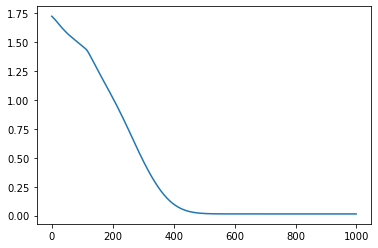

In [17]:
import matplotlib.pyplot as plt
plt.plot(epoch_losses)

In [18]:
g.nodes["fragment"].data["label"]

tensor([1.7740, 1.6490, 1.4550, 1.4560, 1.4340, 1.3500, 1.2180, 1.4960, 1.3940,
        1.3900, 1.3880, 1.3840, 1.3900, 1.3820, 1.3520, 1.3280, 1.3540, 1.3310,
        1.3310, 1.5200, 1.5370, 1.4070, 1.5140, 1.5290, 1.4170, 1.4060, 1.5230,
        1.3880, 1.5260, 1.8530, 1.4130, 1.5230, 1.4050, 1.4060, 1.3770, 1.4140,
        1.4190, 1.3530, 1.4120, 1.3540, 1.3140, 1.4320, 1.3560, 1.3980, 1.3840,
        1.3870, 1.3880, 1.5340, 1.5340, 1.5340, 1.4650, 1.2060, 1.4270, 1.4080,
        1.3940, 1.4770, 1.4140, 1.3690, 1.2120, 1.3360, 1.4640, 1.3540, 1.4970,
        1.4520, 1.3490, 1.4370, 1.3560, 1.4980, 1.4530, 1.3430, 1.4690, 1.5040,
        1.4070, 1.4100, 1.3870, 1.5070, 1.3980, 1.3870, 1.3980, 1.3510, 1.5060,
        1.5230, 1.5350, 1.5380, 1.5360, 1.5270, 1.5480, 1.2490, 1.2490, 1.5360,
        1.7730, 1.6490, 1.4560, 1.4550, 1.4500, 1.3380, 1.2240, 1.4990, 1.3910,
        1.3940, 1.3840, 1.3880, 1.3870, 1.3860, 1.5200, 1.5220, 1.5240, 1.5220,
        1.5310, 1.2220, 1.5260, 1.4430, 

In [20]:
g.nodes["fragment"].data["h"]

tensor([[ 5.4126,  7.5500,  0.0000,  ...,  2.7007,  9.9490,  0.0000],
        [ 5.5622,  7.4045,  0.0000,  ...,  2.9437, 10.1747,  0.0000],
        [ 5.4317,  7.6248,  0.0000,  ...,  3.0698, 10.3782,  0.0000],
        ...,
        [ 5.3486,  7.1885,  0.0000,  ...,  2.0367,  9.4159,  0.0000],
        [ 5.3011,  6.8793,  0.0000,  ...,  2.0127,  9.1700,  0.0000],
        [ 5.3011,  6.8793,  0.0000,  ...,  2.0127,  9.1700,  0.0000]],
       grad_fn=<SumBackward1>)